In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from sklearn import preprocessing
from matplotlib.image import imread
import cv2
from tqdm.notebook import trange, tqdm
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import time
import matplotlib.image as mpimg
from sklearn import cluster, metrics
import os

In [13]:
from random import randint

def colorlist(n):
    color = []

    for i in range(n):
        color.append('#%06X' % randint(0, 0xFFFFFF))
    return(color)

def remove_white_bg(image):
    # 252 => valeur seuil, tout ce qui est au dessus de cette valeur auront la 2e valeur (255) assignée
    _, thresh = cv2.threshold(image, 254, 255, cv2.THRESH_BINARY)
    
    # Inverser pour faire un masque correspondant à l'image
    mask = cv2.bitwise_not(thresh)
    mask = mask.astype(np.uint8)
    
    # appliquer le masque à l'image
    image = cv2.bitwise_and(image, image, mask=mask)
    
    return image

In [174]:
path_out='ImageAnalysis_Figures/'
if not os.path.exists(path_out):
    os.makedirs(path_out)

path = "Flipkart/Images/"

table_id=pd.read_csv('table_id.csv')
table_id['path']=table_id['uniq_id'].astype(str)+'.jpg'
le = preprocessing.LabelEncoder()
table_id["label"] = le.fit_transform(table_id["labels"])
table_id

list_photos=list(table_id['path'].values)
# list_photos

In [ ]:
# Encodage des labels
le = preprocessing.LabelEncoder()
table_id["label"] = le.fit_transform(table_id["labels"])
table_id

### Traitement d'image pour classification
- Transformer les images aux mêmes dimensions
- Passage en noir et blanc
- Egalisation d'histogramme (CLAHE = contrast limited adaptive histogram equalization)
    - Calcul d'histogrammes locaux (tuile par tuile sur l'image)
- Suppression du fond blanc si possible
- Supression du bruit
- Calcul des features SIFT

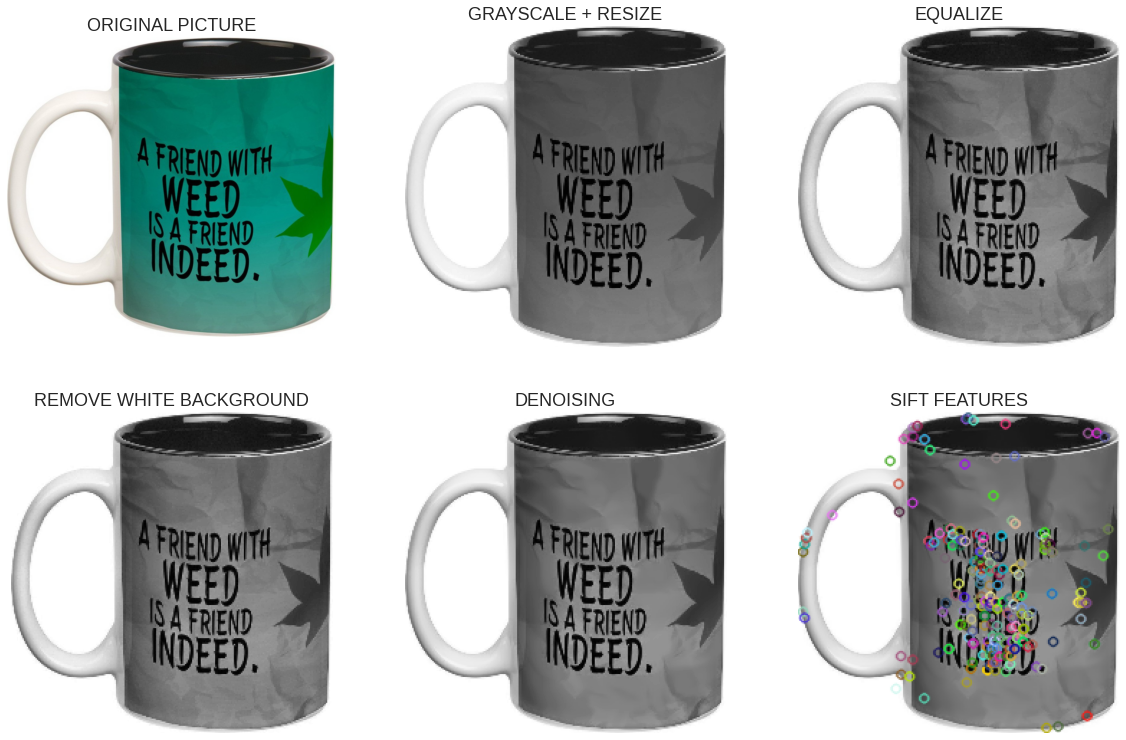

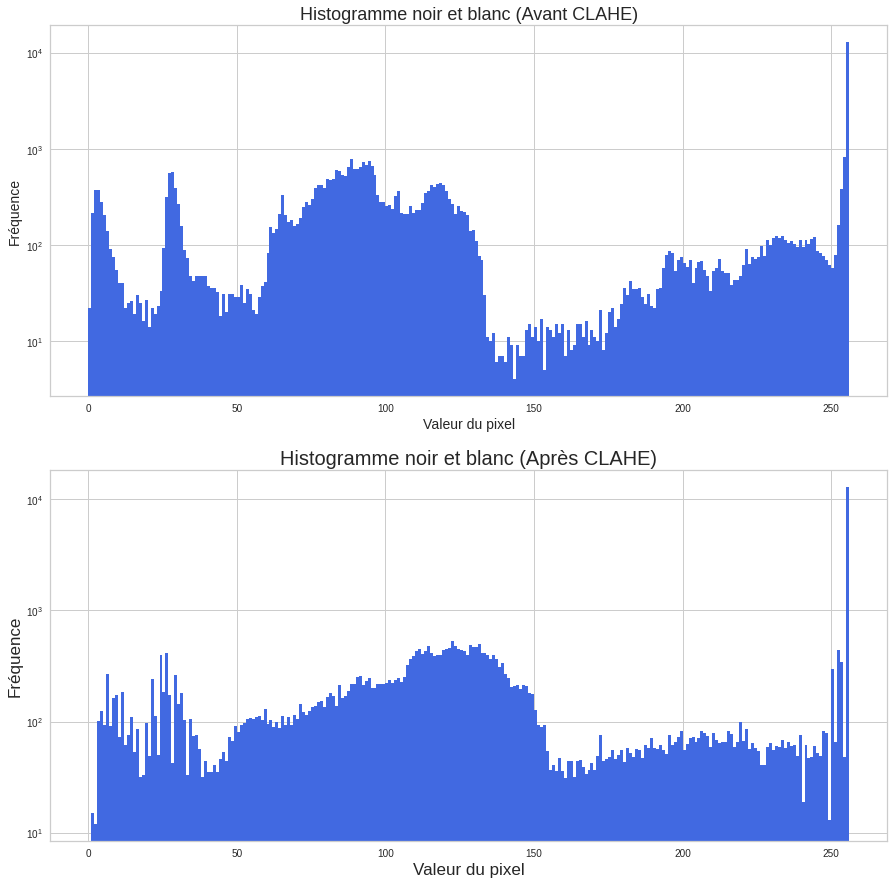

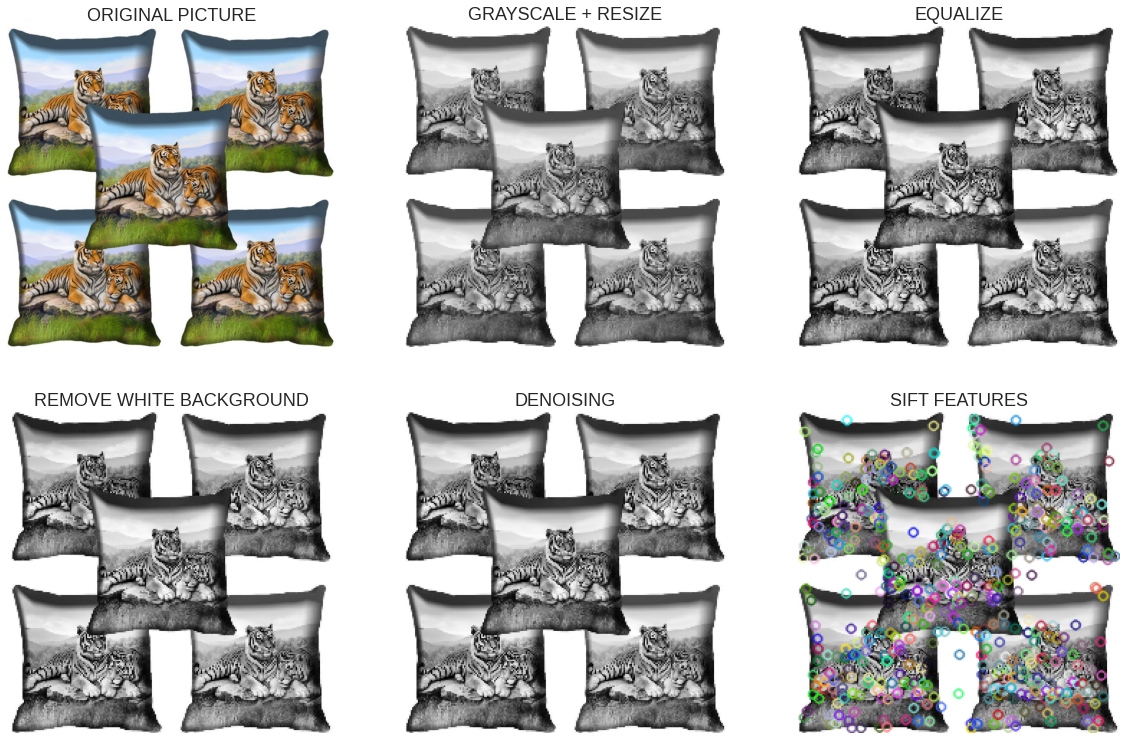

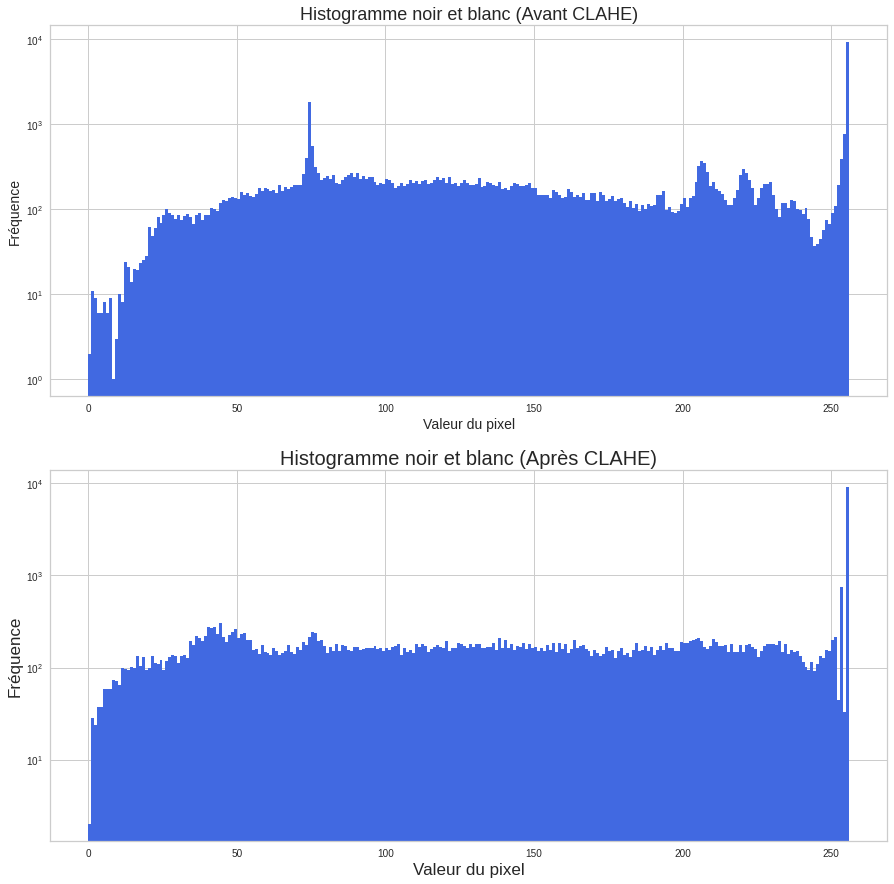

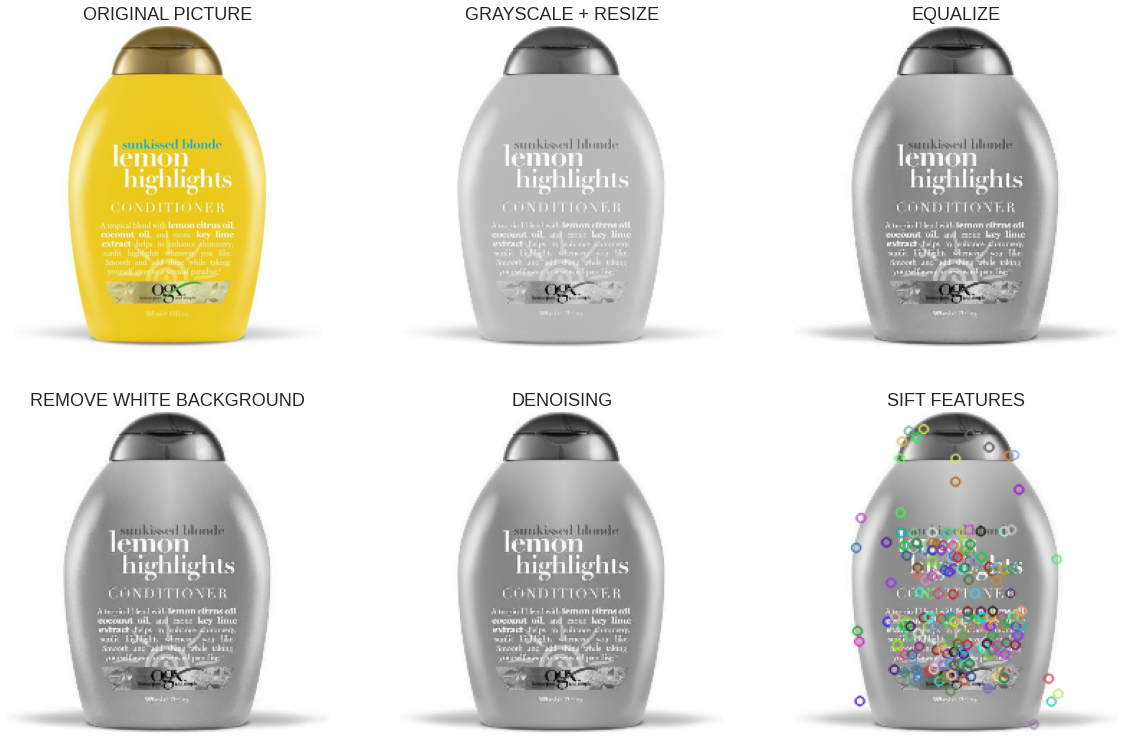

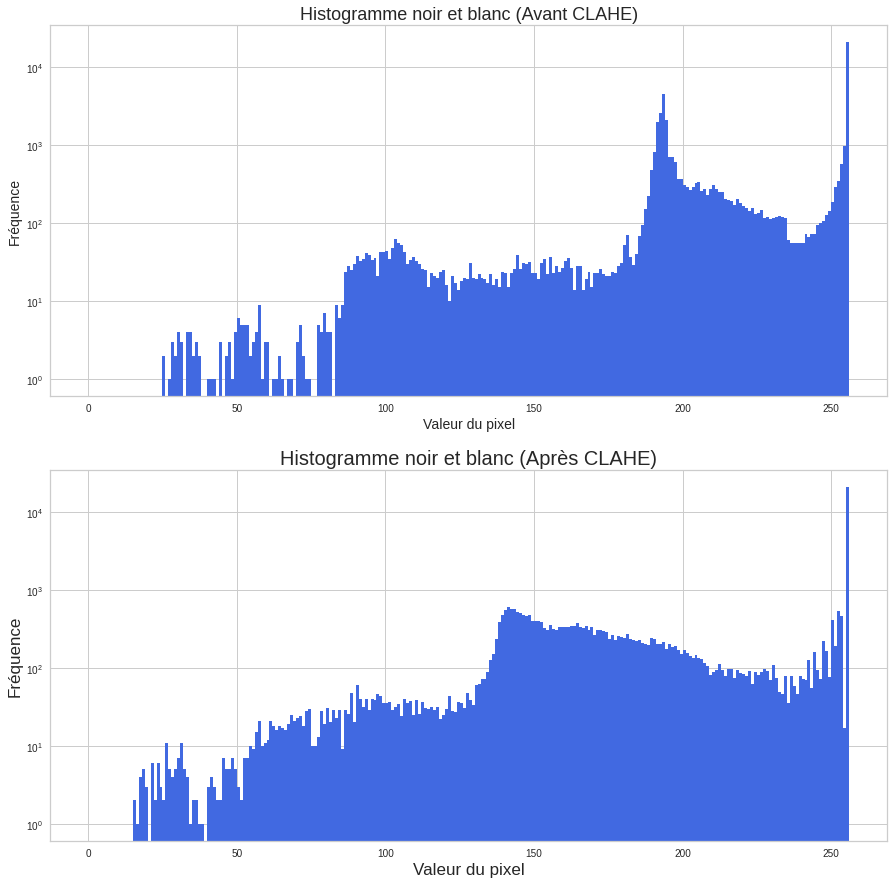

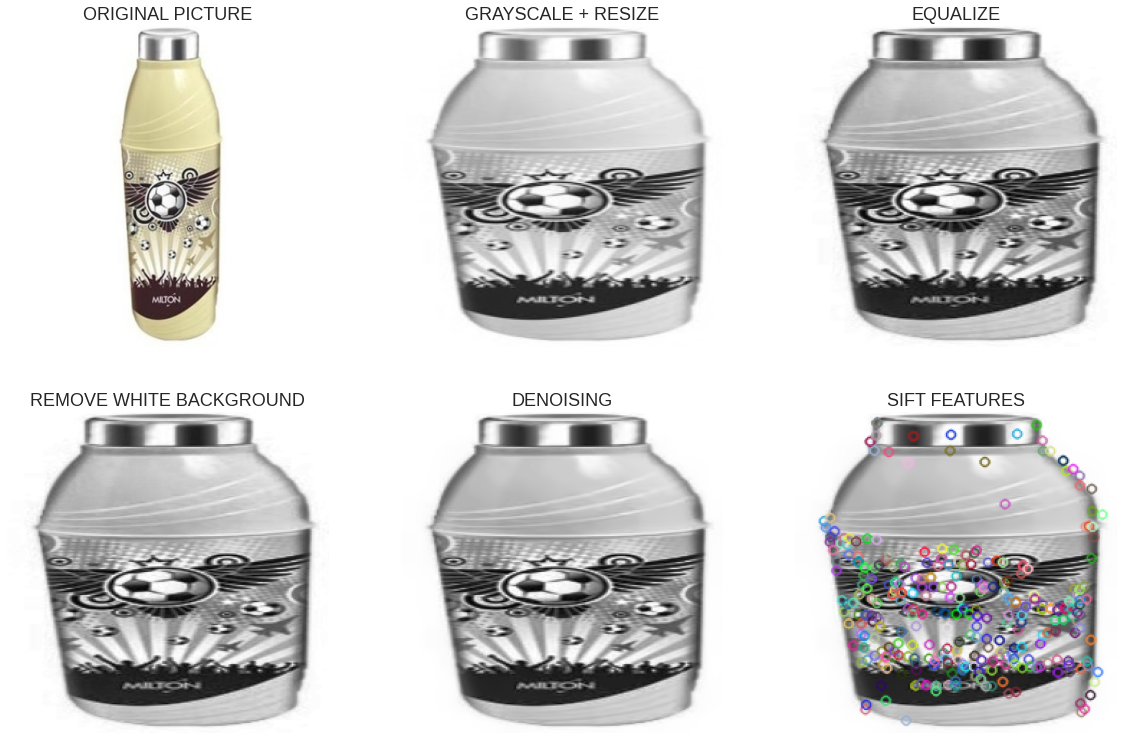

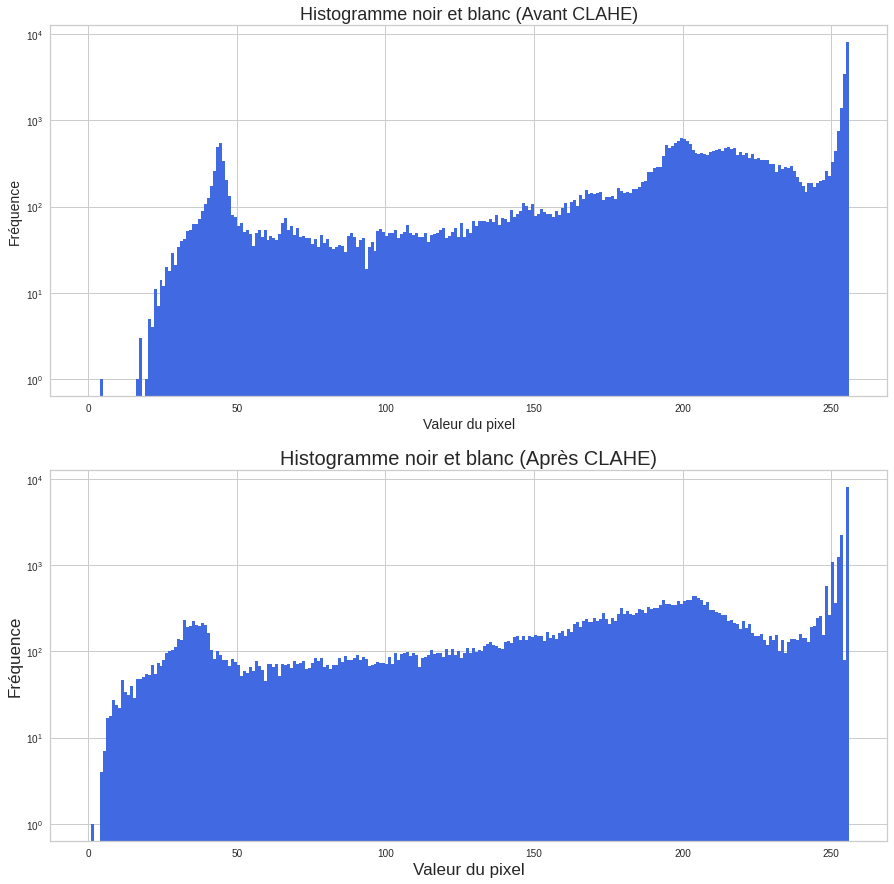

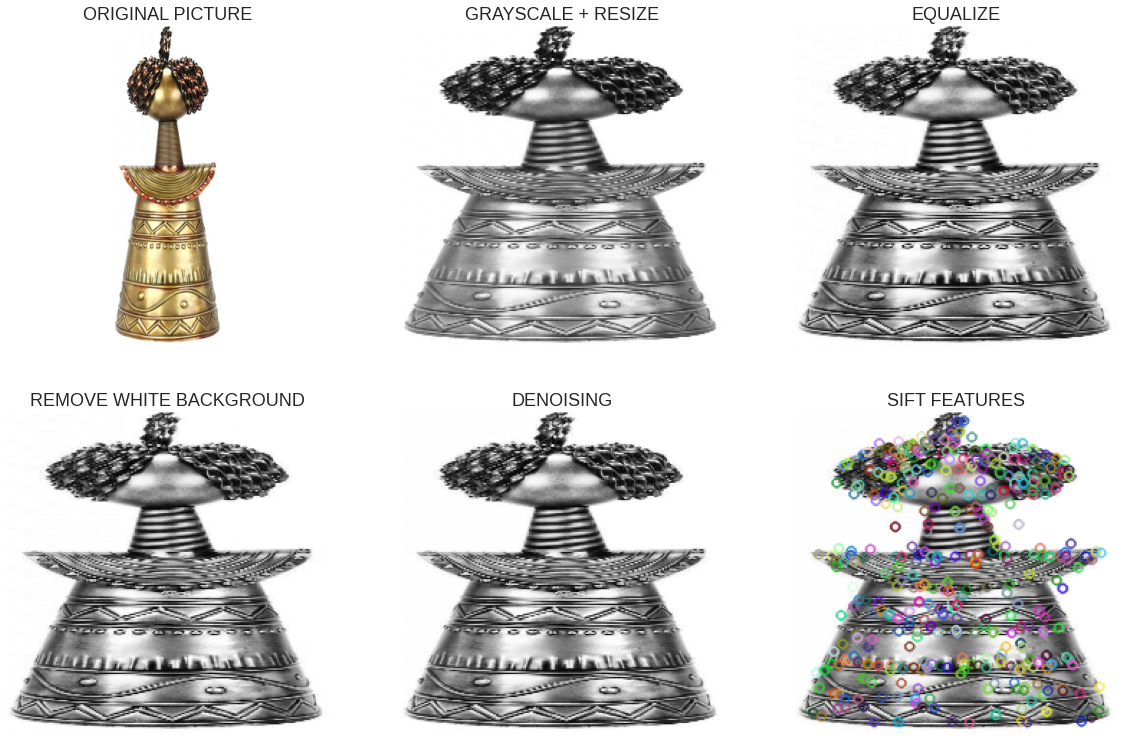

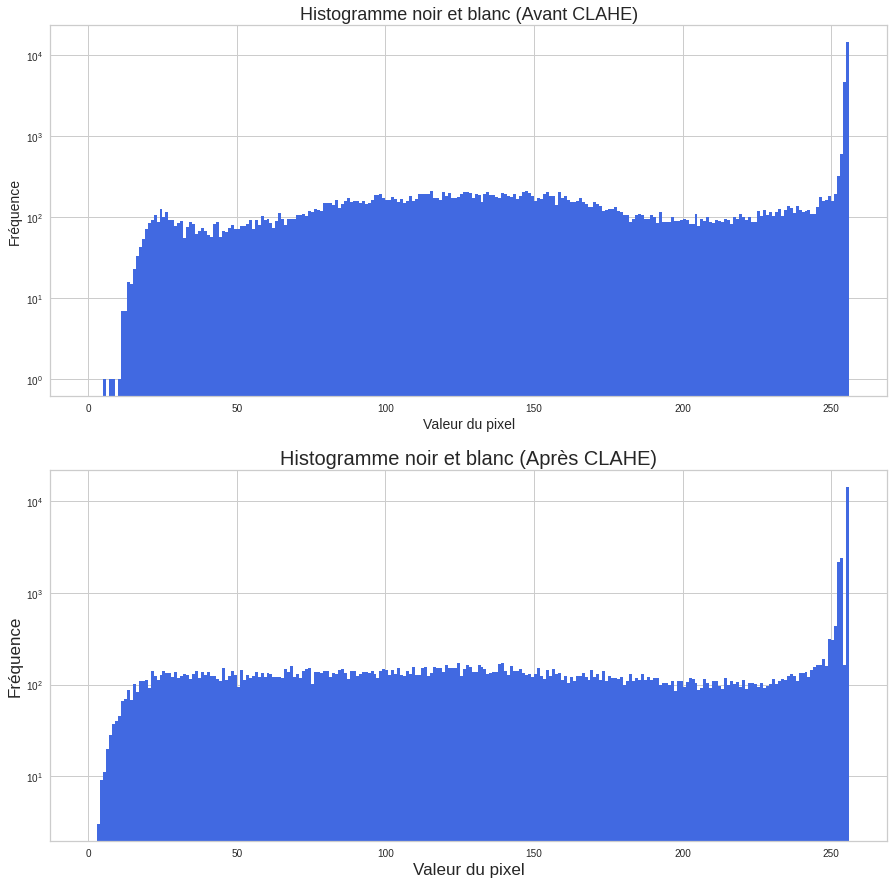

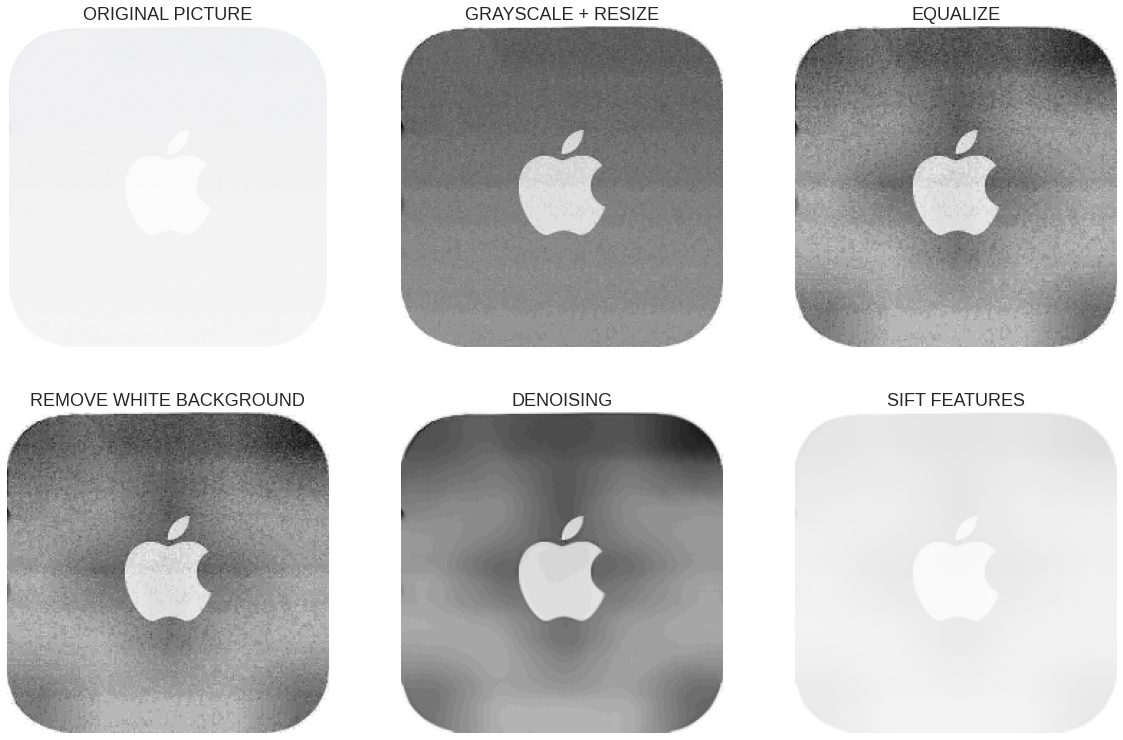

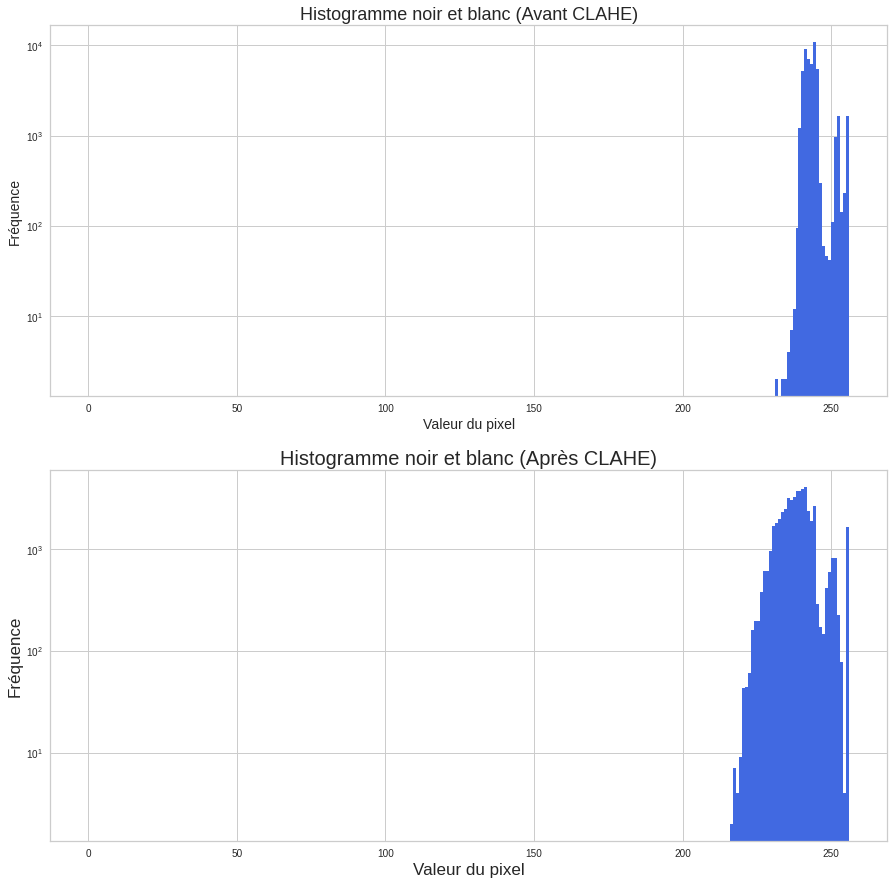

In [120]:
import random

rdm_test = random.sample(list_photos, 5) # selection de 5 images aléatoires
rdm_test.append(list_photos[343]) # ajout d'une image très très claire / quasiment blanche
target_size = (224, 224)

plt.rcParams['image.cmap'] = 'gray'
# cmap par défaut de plt.imshow pr les images à un seul canal (intensité) -> "viridis" 
# donc le grayscale est affiché en nuances de bleu et jaune. Remplacement par une cmap grise

if not os.path.exists("preprocess_pictures"):
    os.makedirs("preprocess_pictures")

for elem in rdm_test:
    
    plt.figure(figsize=(20, 13))

    plt.subplot(2,3,1)
    plt.axis('off')
    plt.title("ORIGINAL PICTURE", size=18)
    plt.imshow(mpimg.imread(path + elem))
    
    sift = cv2.xfeatures2d.SIFT_create()
    
    gr_im = cv2.imread(path + elem, 0)  # 0 = grayscale
    im = cv2.resize(gr_im, target_size, interpolation=cv2.INTER_LINEAR)
       
    plt.subplot(2,3,2)
    plt.axis('off')
    plt.title("GRAYSCALE + RESIZE", size=18)
    plt.imshow(im)

    hist_before=im.ravel() 
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(5, 5))
    im = clahe.apply(im)
    
    
    plt.subplot(2,3,3)
    plt.axis('off')
    plt.title("EQUALIZE", size=18)
    plt.imshow(im)

#    im=remove_white_bg(im)
    
    hist_after=im.ravel()
    
    plt.subplot(2,3,4)
    plt.axis('off')
    plt.title("REMOVE WHITE BACKGROUND", size=18)
    plt.imshow(im)
    
    res = cv2.fastNlMeansDenoising(im, None)

    plt.subplot(2,3,5)
    plt.axis('off')
    plt.title("DENOISING", size=18)
    plt.imshow(res)

    kp, des = sift.detectAndCompute(res, None)
    
    img_kp=cv2.drawKeypoints(res,kp,gr_im)

    plt.subplot(2,3,6)
    plt.axis('off')
    plt.title("SIFT FEATURES", size=18)
    plt.imshow(img_kp)
    
    plt.savefig("preprocess_pictures/"+elem+"_ppc.jpg")    
    plt.show()
    
    plt.close('all')
    
# histogrammes grayscale
    plt.figure(figsize=(15, 15))
    plt.subplot(211)
    plt.hist(hist_before, bins=256, range=(0, 256), color='royalblue', log=True)
    plt.title("Histogramme noir et blanc (Avant CLAHE)", size=18)
    plt.xlabel("Valeur du pixel", size=14)
    plt.ylabel("Fréquence", size=14)

    plt.subplot(212)
    plt.hist(hist_after, bins=256, range=(0, 256), color='royalblue', log=True)
    plt.title("Histogramme noir et blanc (Après CLAHE)", size=20)
    plt.xlabel("Valeur du pixel", size=17)
    plt.ylabel("Fréquence", size=17)
    plt.savefig("preprocess_pictures/"+elem+"_hist_after.jpg")
    plt.show()
    

In [79]:
# identification of key points and associated descriptors
sift_keypoints = []
temps1 = time.time()
target_size = (224, 224)

for elem in tqdm(range(len(list_photos))):
  
    sift = cv2.xfeatures2d.SIFT_create()
    
    im = cv2.imread(path + list_photos[elem], 0)  # 0 = grayscale
    im = cv2.resize(im, target_size, interpolation=cv2.INTER_LINEAR)
    
    clahe = cv2.createCLAHE(clipLimit=40, tileGridSize=(5, 5))
    im = clahe.apply(im)

#    im=remove_white_bg(im) 
    res = cv2.fastNlMeansDenoising(im, None)

    kp, des = sift.detectAndCompute(res, None)

    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1 = time.time() - temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1,
      "secondes")

  0%|          | 0/1050 [00:00<?, ?it/s]


Nombre de descripteurs :  (432622, 128)
temps de traitement SIFT descriptor :            70.40 secondes


/tmp/ipykernel_171303/2464907836.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(sift_keypoints)


In [80]:
# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))

print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=42)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  658
Création de 658 clusters de descripteurs ...
temps de traitement kmeans :             4.96 secondes


In [81]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in tqdm(enumerate(sift_keypoints_by_img)) : 
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0it [00:00, ?it/s]

temps de création histogrammes :             2.16 secondes


In [82]:
# from sklearn.preprocessing import MinMaxScaler

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 658)
Dimensions dataset après réduction PCA :  (1050, 529)


In [83]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=3000, init='random', random_state=42)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = table_id['label']
print(df_tsne.shape)


/home/camille/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


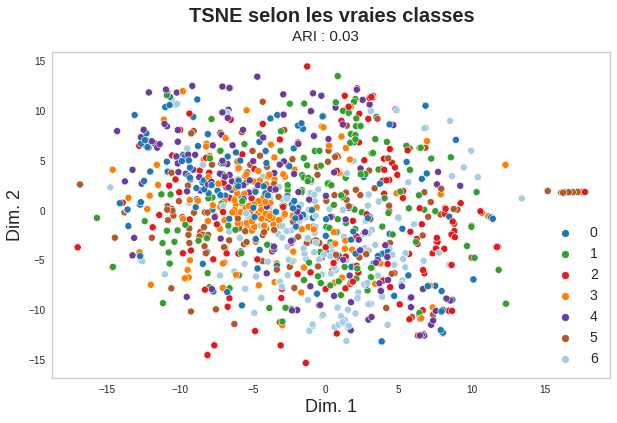

In [184]:
colorlist=['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a', '#b15928', '#a6cee3']

plt.figure(figsize=(10, 6))
sns.scatterplot(x="tsne1",
                y="tsne2",
                hue="class",
                data=df_tsne,
                legend="brief",
                palette=colorlist,
                s=50)

plt.title('TSNE selon les vraies classes', pad=30,fontsize=20, fontweight='bold')
plt.text(0, 17, "ARI : 0.03", ha='center', fontsize=15) 
plt.xlabel('Dim. 1', fontsize=18)
plt.ylabel('Dim. 2', fontsize=18)
plt. grid(False)
plt.legend(prop={'size': 14})
plt.savefig(path_out+"SIFT_vraiesclasses.png")

plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

/tmp/ipykernel_171303/2522219679.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(range(1,10))


Text(0.5, 1.0, 'K-means - Inertie en fonction du nombre de clusters')

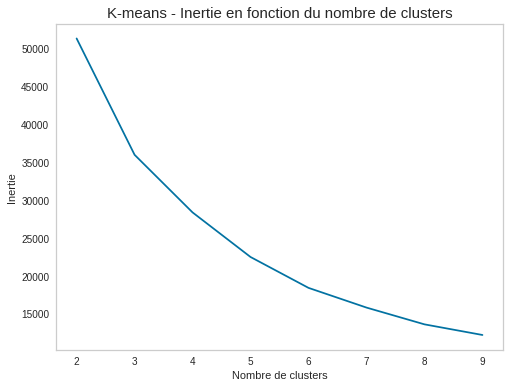

In [85]:
inertia = []
silhouettes=[]

for i in tqdm(range(2, 10)):
    kMeanMod = cluster.KMeans(n_clusters=i)
    kMeanMod.fit(X_tsne)

    inertia.append(kMeanMod.inertia_)
    
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(False)
plt.plot(inertia, zorder=0)
ax.set_xticklabels(range(1,10))
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title("K-means - Inertie en fonction du nombre de clusters", fontsize=15)

In [86]:
cls = cluster.KMeans(n_clusters=table_id.label.nunique(), random_state=42)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


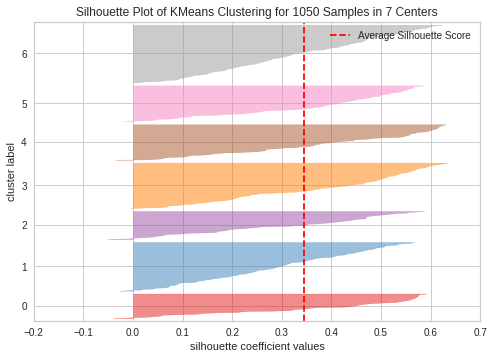

<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 1050 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [87]:
# K-means silhouette score
from yellowbrick.cluster import SilhouetteVisualizer

visualizer = SilhouetteVisualizer(cls)
visualizer.fit(X_tsne) 

visualizer.show()

In [88]:
len(cls.labels_)

1050

In [89]:
print("ARI : ", metrics.adjusted_rand_score( table_id["label"], cls.labels_))

ARI :  0.03781201031887966


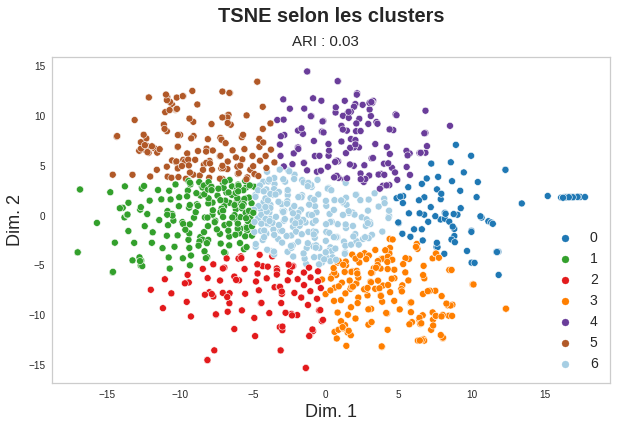

ARI :  0.03781201031887966


In [178]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="tsne1",
                y="tsne2",
                hue="cluster",
                palette=colorlist,
                data=df_tsne,
                legend="brief")

plt.title('TSNE selon les clusters', pad=35,fontsize=20, fontweight='bold')
plt.text(0, 17, "ARI : 0.03", ha='center', fontsize=15) 
plt.xlabel('Dim. 1', fontsize=18)
plt.ylabel('Dim. 2', fontsize=18)
plt. grid(False)
plt.legend(prop={'size': 14})
plt.savefig(path_out+"SIFT_clusters.png")
plt.show()

labels = table_id["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

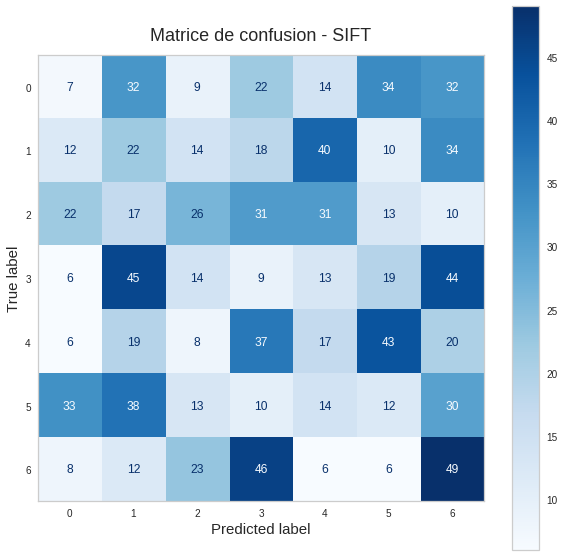

In [187]:
cm = confusion_matrix(table_id["label"].values, cls.labels_)

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(cm).plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Matrice de confusion - SIFT", size=18, pad=15)
plt.ylabel("True label",size=15)
plt.xlabel("Predicted label",size=15)
plt.grid(False)
plt.savefig(path_out+"CMatrix.png", bbox_inches="tight")
plt.show()